## Setup and imports

In [59]:
import pandas as pd
from textblob import TextBlob
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import json
import nltk
import seaborn as sns
from wordcloud import WordCloud
from datasketch import MinHash, MinHashLSH
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
nltk.download('wordnet')
import contractions
import pandas as pd
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community.quality import modularity
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importing dataset

In [58]:
file_path = "../data/fake_reviews_dataset.csv"
df = pd.read_csv(file_path)

## Data Preprocessing

In [20]:
df = df.rename(columns={'text_':'text'}) #Change column name text_ to text
df.drop_duplicates() #Drop duplicates

In [22]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_textual_data(df, column_name):
    """
    Preprocesses the review text column in the following steps:
    1.Tokenization
    2.Punctuation removal
    3.Stopword removal
    4.Lemmatization
    5.Numerical character removal

    """
    def preprocess_text(text):
        tokens = word_tokenize(text)

        tokens = [token for token in tokens if token not in set(string.punctuation)]

        tokens = [token for token in tokens if token.lower() not in stopwords.words('english')]
        
        lem = WordNetLemmatizer()
        for part_of_speech in ['n', 'v', 'a', 'r', 's']:
            tokens = [lem.lemmatize(token, part_of_speech).lower() for token in tokens]

        tokens = [token for token in tokens if token.isalnum() and not token.isdigit() and len(token) >= 2]
        tokens = [token for token in tokens if not any(char.isdigit() for char in token)]

        return tokens
    df['processed_text'] = df[column_name].apply(preprocess_text)
    
    return df


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Apply function to the dataframe

In [23]:
df = preprocess_textual_data(df, column_name='text' )

## Visualisations

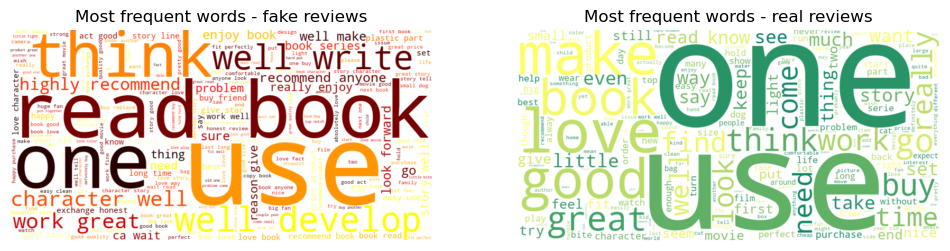

In [142]:
# Generating word clouds to identify the most frequent words for both real and fake reviews
cg_text = ' '.join([' '.join(words) for words in df[df['label'] == 'CG']['processed_text']])
or_text = ' '.join([' '.join(words) for words in df[df['label'] == 'OR']['processed_text']])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
cg_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='hot').generate(cg_text)
plt.imshow(cg_wordcloud, interpolation='bilinear')
plt.title('Most frequent words - fake reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
or_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='summer').generate(or_text)
plt.imshow(or_wordcloud, interpolation='bilinear')
plt.title('Most frequent words - real reviews')
plt.axis('off')

plt.show()

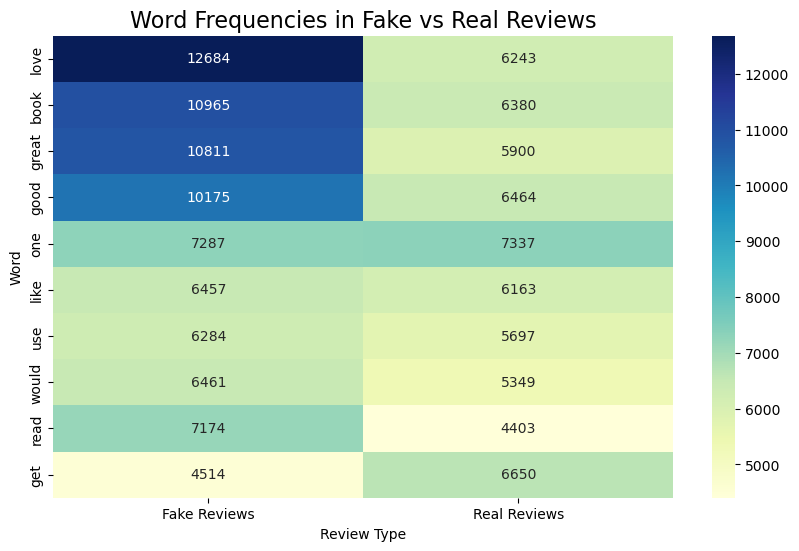

In [26]:
#word frequencies for fake and real reviews
cg_word_counts = Counter(cg_text.split())
or_word_counts = Counter(or_text.split())

words = list(set(cg_word_counts.keys()).union(or_word_counts.keys()))
word_frequencies = pd.DataFrame({
    "Word": words,
    "Fake reviews": [cg_word_counts.get(word, 0) for word in words],
    "Real reviews": [or_word_counts.get(word, 0) for word in words]
}).set_index("Word")

top_words = word_frequencies.sum(axis=1).nlargest(10).index
heatmap_data = word_frequencies.loc[top_words]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Word frequencies for fake vs real reviews", fontsize=16)
plt.show()

# Veit ekki hvort þetta þurfi að vera en whatever

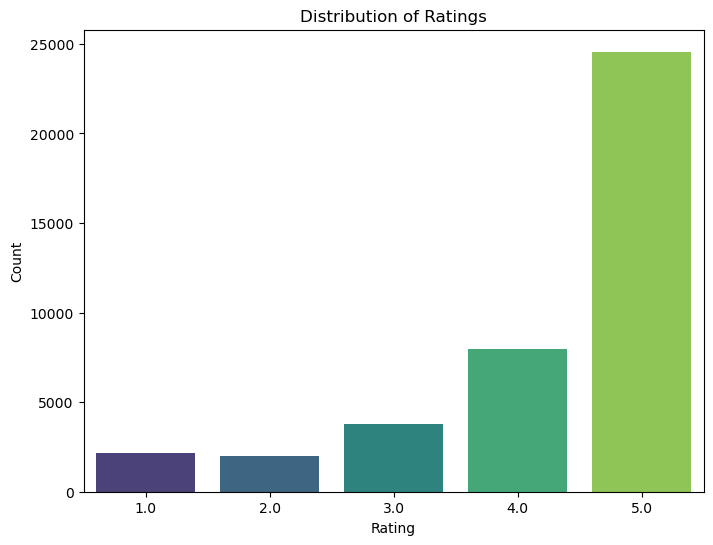

In [61]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

/var/folders/9w/dgxmbyyn2hl1p64rjgpmgw880000gn/T/ipykernel_12895/1687703350.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




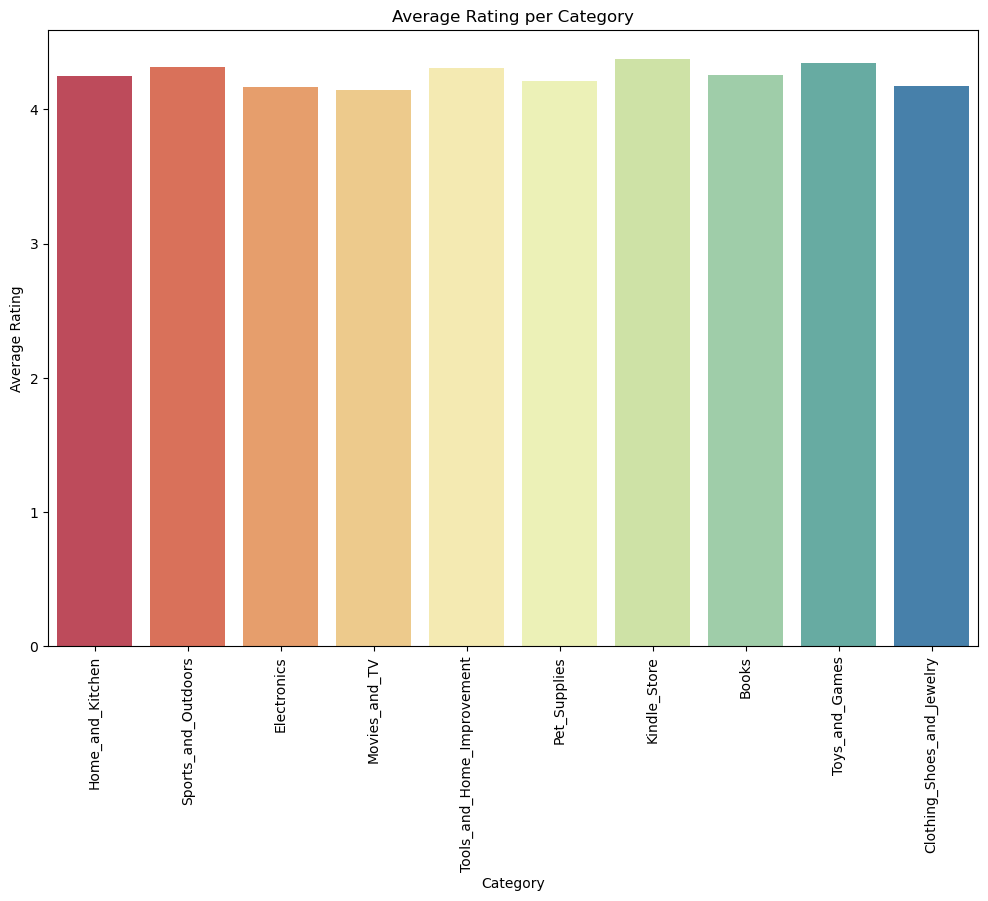

In [72]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='category', y='rating', estimator='mean', ci=None, palette='Spectral')
plt.xticks(rotation=90)
plt.title('Average rating per category')
plt.xlabel('Category')
plt.ylabel('Average rating')
plt.show()

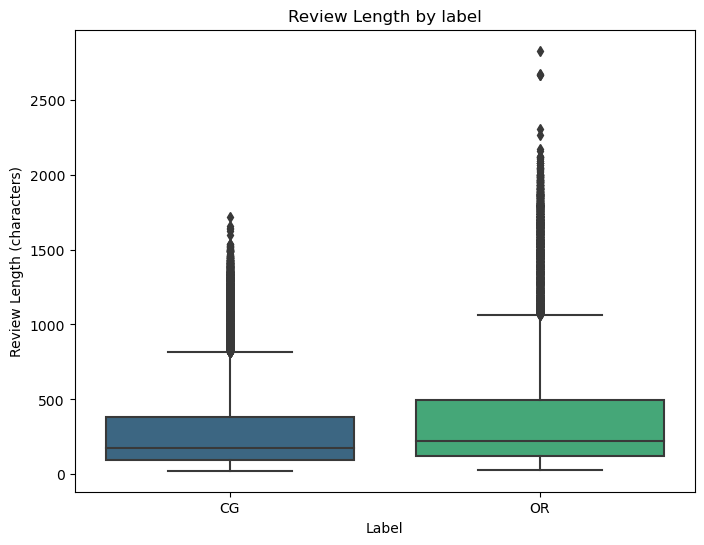

In [73]:
df['review_length'] = df['text'].apply(len)

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='label', y='review_length', palette='viridis')
plt.title('Review Length by label')
plt.xlabel('Label')
plt.ylabel('Review Length (characters)')
plt.show()

## Frequent items: A-Priori Algorithm

## FAKE vs REAL

In [48]:
# splitting data into real and fake reviews
real_reviews_df = df[df['label'] == "OR"]  
fake_reviews_df = df[df['label'] == "CG"]  

In [49]:
# creating baskets for both real and fake review text data
real_baskets = real_reviews_df['processed_text'].tolist()
fake_baskets = fake_reviews_df['processed_text'].tolist()

In [50]:
# encoding real reviews
te = TransactionEncoder()
real_encoded = te.fit(real_baskets).transform(real_baskets)
real_df = pd.DataFrame(real_encoded, columns=te.columns_)

# frequent itemsets for real reviews
real_itemsets = apriori(real_df, min_support=0.05, use_colnames=True)
num_itemsets_real=len(real_itemsets)

# association rules for real reviews
real_rules = association_rules(real_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=num_itemsets_real)

In [51]:
# encoding fake reviews
te = TransactionEncoder()
fake_encoded = te.fit(fake_baskets).transform(fake_baskets)
fake_df = pd.DataFrame(fake_encoded, columns=te.columns_)

# frequent itemsets for real reviews
fake_itemsets = apriori(fake_df, min_support=0.05, use_colnames=True)
num_itemsets_fake = len(fake_itemsets)

# association rules for real reviews
fake_rules = association_rules(fake_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=num_itemsets_fake)

## Investigating the number of unique tokens in real vs fake reviews

In [30]:
real_vocab = set([word for basket in real_baskets for word in basket])
fake_vocab = set([word for basket in fake_baskets for word in basket])

print("Number of unique tokens in real reviews:", len(real_vocab))
print("Number of unique tokens in fake reviews:", len(fake_vocab))


Number of unique tokens in real reviews: 27736
Number of unique tokens in fake reviews: 9004


## Investigating the number of frequent itemsets in real vs fake reviews

In [31]:
print("Number of frequent itemsets for real reviews:", len(real_itemsets))
print("Number of frequent itemsets for fake reviews:", len(fake_itemsets))

Number of frequent itemsets for real reviews: 229
Number of frequent itemsets for fake reviews: 496


## Lets test different thresholds for min support threshold to see the number of itemsets

In [53]:
thresholds = [0.02, 0.03, 0.05, 0.07]
for threshold in thresholds:
    fake_itemsets = apriori(fake_df, min_support=threshold, use_colnames=True)
    real_itemsets = apriori(real_df, min_support=threshold, use_colnames=True)
    print(f"Threshold: {threshold}")
    print(f"Number of fake itemsets: {len(fake_itemsets)}, Number of real itemsets: {len(real_itemsets)}")


Threshold: 0.02
Fake Itemsets: 3922, Real Itemsets: 1195
Threshold: 0.03
Fake Itemsets: 1134, Real Itemsets: 442
Threshold: 0.05
Fake Itemsets: 272, Real Itemsets: 138
Threshold: 0.07
Fake Itemsets: 108, Real Itemsets: 67


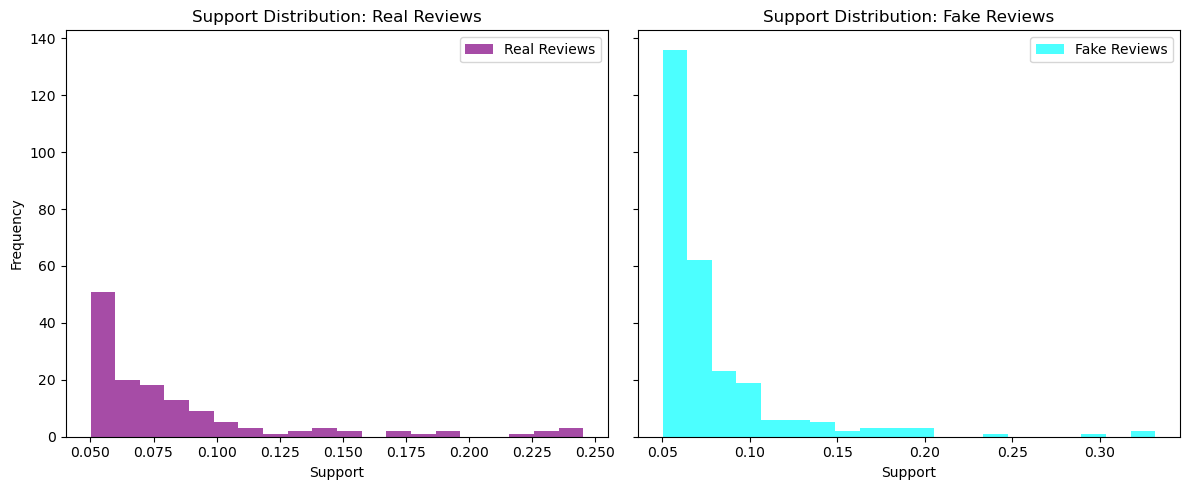

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# real review support distribution
axes[0].hist(real_itemsets['support'], bins=20, color='purple', alpha=0.7, label='Real Reviews')
axes[0].set_title('Support Distribution: Real Reviews')
axes[0].set_xlabel('Support')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Fake Reviews Support Distribution
axes[1].hist(fake_itemsets['support'], bins=20, color='cyan', alpha=0.7, label='Fake Reviews')
axes[1].set_title('Support Distribution: Fake Reviews')
axes[1].set_xlabel('Support')
axes[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()
